In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/home/antonio/uni/tesi/mujoco_mpc/experiments/h1_teleop_test/2024-09-09_16-10-24/data.csv')

data['delta_x'] = data['x'].diff()
data['delta_y'] = data['y'].diff()
data['delta_theta'] = data['theta'].diff()

data['prev_vx'] = data['vx'].shift(1)
data['prev_vy'] = data['vy'].shift(1)
data['prev_omega'] = data['omega'].shift(1)

forward_policy = data.loc[data['command'] == 'FORWARD']
right_policy = data.loc[data['command'] == 'RIGHT']
left_policy = data.loc[data['command'] == 'LEFT']



In [45]:
print("Data ranges")
cols = ['x', 'y', 'theta', 'vx', 'vy', 'omega', 'delta_x', 'delta_y', 'delta_theta', 'prev_vx', 'prev_vy', 'prev_omega']
for col in cols:
    print(f"{col}: {data[col].min()} - {data[col].max()}")

Data ranges
x: -0.0020927133830065 - 4.997130637108016
y: -0.4883309582630504 - 2.9686240017590126
theta: -3.1413279336873394 - 3.1414698513627526
vx: -0.6358895559719963 - 0.7453282882250113
vy: -0.5209009283374277 - 0.6808111705459325
omega: -6.7969171427339 - 6.761901448023125
delta_x: -0.0012717791119429833 - 0.001490656576450089
delta_y: -0.0010418018566748025 - 0.0013616223410919115
delta_theta: -6.282797785050092 - 6.280975528419811
prev_vx: -0.6358895559719963 - 0.7453282882250113
prev_vy: -0.5209009283374277 - 0.6808111705459325
prev_omega: -6.7969171427339 - 6.761901448023125


In [46]:
vx_error = forward_policy.loc[:, 'delta_x']/0.002 - forward_policy.loc[:, 'prev_vx']
print(vx_error.mean())

vy_error = forward_policy.loc[:, 'delta_y']/0.002 - forward_policy.loc[:, 'prev_vy']
print(vy_error.mean())

omega_error = forward_policy.loc[:, 'delta_theta']/0.002 - forward_policy.loc[:, 'prev_omega']
print(omega_error.mean())

-1.2281794458001015e-05
4.720224419666299e-05
0.0013522823320316897


In [47]:
print("Mean and std")
print("FORWARD")
fw_stats = pd.DataFrame()
fw_stats['mean'] = forward_policy.loc[:, cols].mean()
fw_stats['std'] = forward_policy.loc[:, cols].std()
print(fw_stats)
print("RIGHT")
right_stats = pd.DataFrame()
right_stats['mean'] = right_policy.loc[:, cols].mean()
right_stats['std'] = right_policy.loc[:, cols].std()
print(right_stats)
print("LEFT")
left_stats = pd.DataFrame()
left_stats['mean'] = left_policy.loc[:, cols].mean()
left_stats['std'] = left_policy.loc[:, cols].std()
print(left_stats)

Mean and std
FORWARD
                 mean       std
x            2.664947  1.626548
y            0.661024  0.664184
theta        0.657937  1.015623
vx           0.191182  0.257158
vy           0.114717  0.232830
omega        0.035620  0.932302
delta_x      0.000382  0.000514
delta_y      0.000229  0.000466
delta_theta  0.000073  0.097579
prev_vx      0.191194  0.256914
prev_vy      0.114670  0.232728
prev_omega   0.035120  0.932046
RIGHT
                 mean       std
x            2.510960  1.527084
y            0.614668  1.065287
theta        0.589095  1.720673
vx           0.059650  0.296363
vy           0.031728  0.254751
omega       -1.405398  1.396356
delta_x      0.000119  0.000593
delta_y      0.000063  0.000510
delta_theta -0.001050  0.105434
prev_vx      0.059377  0.296731
prev_vy      0.031549  0.254889
prev_omega  -1.402440  1.400489
LEFT
                     mean       std
x            3.648162e+00  0.678681
y            1.267964e+00  0.676955
theta        7.278268e-01  1

array([[<Axes: title={'center': 'omega'}>]], dtype=object)

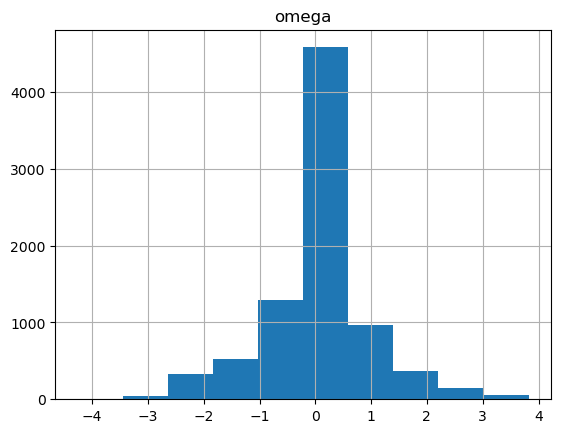

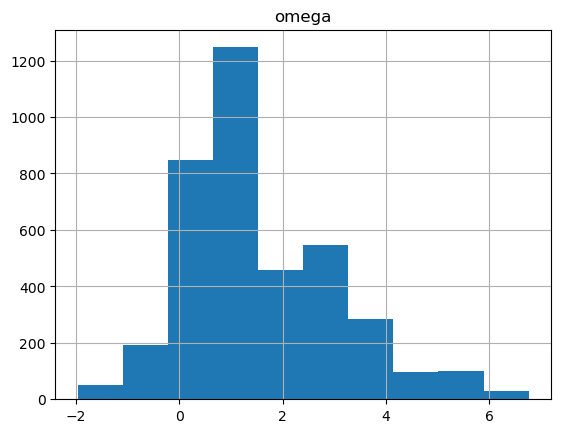

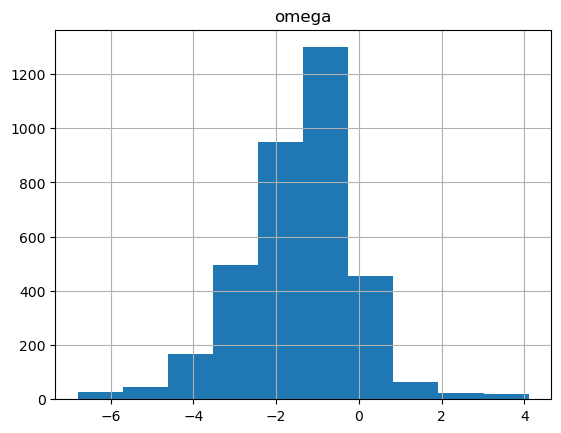

In [48]:
forward_policy.hist(column='omega', bins=10)
left_policy.hist(column='omega', bins=10)
right_policy.hist(column='omega', bins=10)

# Regression with OLS

In [88]:

fw_arr = forward_policy[['prev_vx', 'prev_vy', 'prev_omega','vx','vy','omega']].to_numpy()
fw_arr = np.stack(np.split(fw_arr, 2, axis=1), axis=1)


fw_exog = fw_arr[:,0,:]
fw_exog = np.append(fw_exog, np.ones((fw_arr.shape[0], 1)), axis=1)
fw_endog = fw_arr[:,1,:]

left_arr = left_policy[['prev_vx', 'prev_vy', 'prev_omega','vx','vy','omega']].to_numpy()
left_arr = np.stack(np.split(left_arr, 2, axis=1), axis=1)

left_exog = left_arr[:,0,:]
left_exog = np.append(left_exog, np.ones((left_arr.shape[0], 1)), axis=1)
left_endog = left_arr[:,1,:]

right_arr = right_policy[['prev_vx', 'prev_vy', 'prev_omega','vx','vy','omega']].to_numpy()
right_arr = np.stack(np.split(right_arr, 2, axis=1), axis=1)    

right_exog = right_arr[:,0,:]
right_exog = np.append(right_exog, np.ones((right_arr.shape[0], 1)), axis=1)
right_endog = right_arr[:,1,:]

In [129]:
import statsmodels.regression.linear_model as sm

fw_vx_model = sm.OLS(fw_endog[:,0], fw_exog).fit()
fw_vy_model = sm.OLS(fw_endog[:,1], fw_exog).fit()
fw_omega_model = sm.OLS(fw_endog[:,2], fw_exog).fit()

left_vx_model = sm.OLS(left_endog[:,0], left_exog).fit()
left_vy_model = sm.OLS(left_endog[:,1], left_exog).fit()
left_omega_model = sm.OLS(left_endog[:,2], left_exog).fit()

right_vx_model = sm.OLS(right_endog[:,0], right_exog).fit()
right_vy_model = sm.OLS(right_endog[:,1], right_exog).fit()
right_omega_model = sm.OLS(right_endog[:,2], right_exog).fit()

Text(0.5, 1.0, 'Right omega')

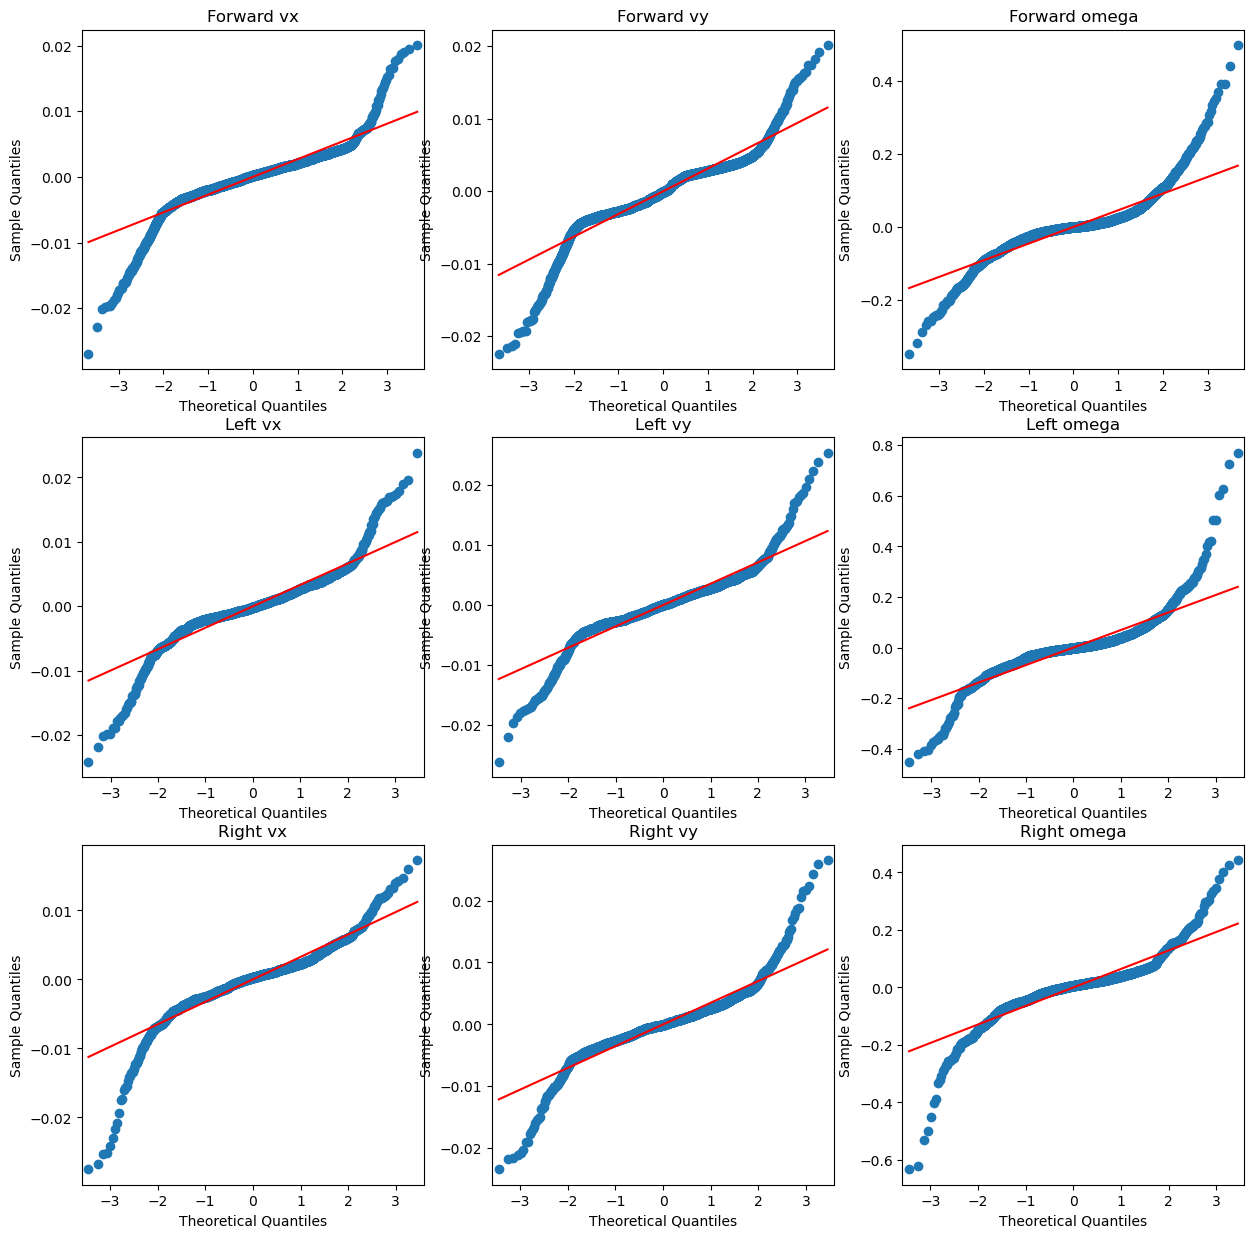

In [130]:
#plot qq plot
import statsmodels.api as sm_api
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
sm_api.qqplot(fw_vx_model.resid, line='s', ax=ax[0,0])
ax[0,0].set_title('Forward vx')
sm_api.qqplot(fw_vy_model.resid, line='s', ax=ax[0,1])
ax[0,1].set_title('Forward vy')
sm_api.qqplot(fw_omega_model.resid, line='s', ax=ax[0,2])
ax[0,2].set_title('Forward omega')
sm_api.qqplot(left_vx_model.resid, line='s', ax=ax[1,0])
ax[1,0].set_title('Left vx')
sm_api.qqplot(left_vy_model.resid, line='s', ax=ax[1,1])
ax[1,1].set_title('Left vy')
sm_api.qqplot(left_omega_model.resid, line='s', ax=ax[1,2])
ax[1,2].set_title('Left omega')
sm_api.qqplot(right_vx_model.resid, line='s', ax=ax[2,0])
ax[2,0].set_title('Right vx')
sm_api.qqplot(right_vy_model.resid, line='s', ax=ax[2,1])
ax[2,1].set_title('Right vy')
sm_api.qqplot(right_omega_model.resid, line='s', ax=ax[2,2])
ax[2,2].set_title('Right omega')

Text(0.5, 1.0, 'Right omega')

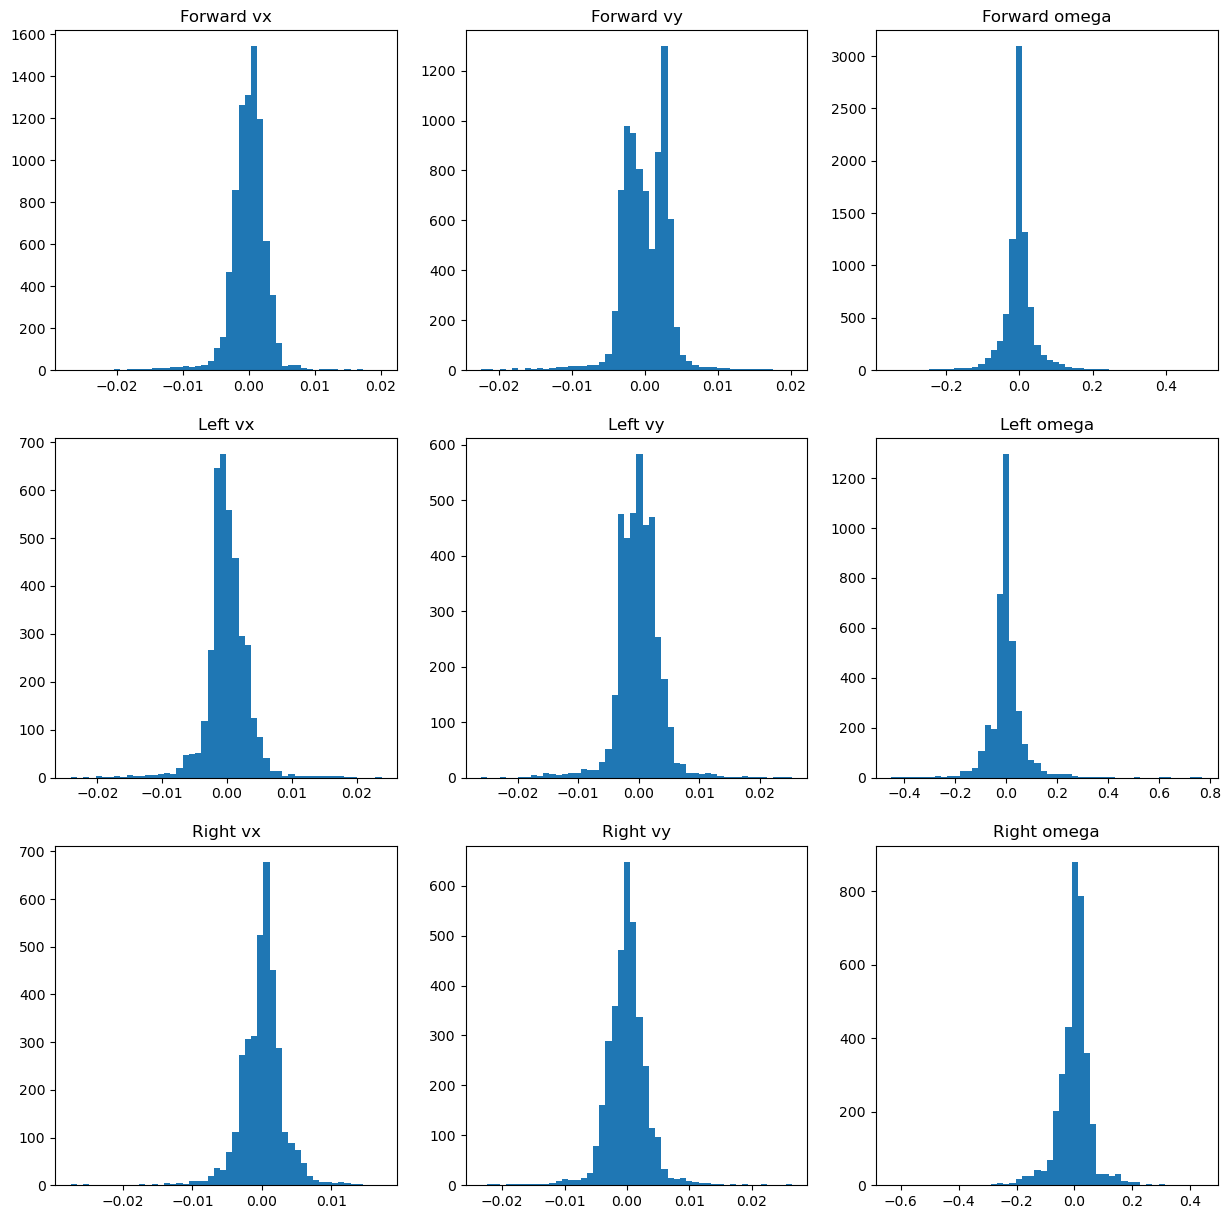

In [127]:
#plot residuals histogram
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0,0].hist(fw_vx_model.resid, bins=50)
ax[0,0].set_title('Forward vx')
ax[0,1].hist(fw_vy_model.resid, bins=50)
ax[0,1].set_title('Forward vy')
ax[0,2].hist(fw_omega_model.resid, bins=50)
ax[0,2].set_title('Forward omega')
ax[1,0].hist(left_vx_model.resid, bins=50)
ax[1,0].set_title('Left vx')
ax[1,1].hist(left_vy_model.resid, bins=50)
ax[1,1].set_title('Left vy')
ax[1,2].hist(left_omega_model.resid, bins=50)
ax[1,2].set_title('Left omega')
ax[2,0].hist(right_vx_model.resid, bins=50)
ax[2,0].set_title('Right vx')
ax[2,1].hist(right_vy_model.resid, bins=50)
ax[2,1].set_title('Right vy')
ax[2,2].hist(right_omega_model.resid, bins=50)
ax[2,2].set_title('Right omega')

In [131]:
#heteriscedasticity test
import statsmodels.stats.diagnostic as sm_diag
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sm_diag.het_breuschpagan(fw_vx_model.resid, fw_exog)
print("Forward vx")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(fw_vy_model.resid, fw_exog)
print("Forward vy")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(fw_omega_model.resid, fw_exog)
print("Forward omega")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(left_vx_model.resid, left_exog)
print("Left vx")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(left_vy_model.resid, left_exog)
print("Left vy")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(left_omega_model.resid, left_exog)
print("Left omega")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(right_vx_model.resid, right_exog)
print("Right vx")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(right_vy_model.resid, right_exog)
print("Right vy")
print(list(zip(name, test)))
test = sm_diag.het_breuschpagan(right_omega_model.resid, right_exog)
print("Right omega")
print(list(zip(name, test)))

Forward vx
[('Lagrange multiplier statistic', 130.3835207866642), ('p-value', 4.471188809745976e-28), ('f-value', 44.13409215671875), ('f p-value', 2.7488141840354852e-28)]
Forward vy
[('Lagrange multiplier statistic', 83.15738479613495), ('p-value', 6.4509735512328685e-18), ('f-value', 27.98638962532839), ('f p-value', 5.334819736681951e-18)]
Forward omega
[('Lagrange multiplier statistic', 60.69945385234649), ('p-value', 4.166768652802917e-13), ('f-value', 20.372505844980935), ('f p-value', 3.780877652944699e-13)]
Left vx
[('Lagrange multiplier statistic', 73.21185910264977), ('p-value', 8.755734349974263e-16), ('f-value', 24.850933096600023), ('f p-value', 6.392838311241102e-16)]
Left vy
[('Lagrange multiplier statistic', 29.94282268679011), ('p-value', 1.4188088341735494e-06), ('f-value', 10.048688123827347), ('f p-value', 1.3585088383876993e-06)]
Left omega
[('Lagrange multiplier statistic', 61.85665701663666), ('p-value', 2.357702609985151e-13), ('f-value', 20.9336336087543), ('f

In [132]:
models = [fw_vx_model, fw_vy_model, fw_omega_model, left_vx_model, left_vy_model, left_omega_model, right_vx_model, right_vy_model, right_omega_model]
for model in models:
    display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.497e+07
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 37266.
No. Observations:                8293   AIC:                        -7.452e+04
Df Residuals:                    8289   BIC:                        -7.450e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0009      0.000   8474.553      0.000       1.001       1.001
x2         -8.638e-05      0.000     -0.658      0.510      -0.000       0.000
x3             0.0004   3.21e-05     11.869      0.000       0.000       0.000
const         -0.0002   4.18e-05     -4.708      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     2497.531   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45116.128
Skew:                          -0.977   Prob(JB):                         0.00
Kurtosis:                      14.258   Cond. No.                         4.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.516e+07
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 36023.
No. Observations:                8293   AIC:                        -7.204e+04
Df Residuals:                    8289   BIC:                        -7.201e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0001      0.000     -0.837      0.403      -0.000       0.000
x2             1.0005      0.000   6564.582      0.000       1.000       1.001
x3            -0.0003   3.73e-05     -8.603      0.000      -0.000      -0.000
const       2.553e-05   4.86e-05      0.525      0.600   -6.98e-05       0.000
==============================================================================
Omnibus:                     1339.649   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11377.435
Skew:                          -0.524   Prob(JB):                         0.00
Kurtosis:                       8.642   Cond. No.                         4.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.145e+06
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 13816.
No. Observations:                8293   AIC:                        -2.762e+04
Df Residuals:                    8289   BIC:                        -2.760e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0033      0.002     -1.656      0.098      -0.007       0.001
x2             0.0067      0.002      3.029      0.002       0.002       0.011
x3             0.9988      0.001   1838.411      0.000       0.998       1.000
const          0.0004      0.001      0.571      0.568      -0.001       0.002
==============================================================================
Omnibus:                     2518.923   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59142.737
Skew:                           0.911   Prob(JB):                         0.00
Kurtosis:                      15.955   Cond. No.                         4.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.697e+06
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 16524.
No. Observations:                3852   AIC:                        -3.304e+04
Df Residuals:                    3848   BIC:                        -3.302e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9991      0.000   4370.005      0.000       0.999       1.000
x2            -0.0012      0.000     -6.042      0.000      -0.002      -0.001
x3             0.0004    3.6e-05     12.278      0.000       0.000       0.001
const         -0.0007   8.03e-05     -8.651      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      659.926   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11444.166
Skew:                          -0.267   Prob(JB):                         0.00
Kurtosis:                      11.427   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.524e+06
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 16268.
No. Observations:                3852   AIC:                        -3.253e+04
Df Residuals:                    3848   BIC:                        -3.250e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0001      0.000     -0.583      0.560      -0.001       0.000
x2             1.0000      0.000   4633.071      0.000       1.000       1.000
x3            -0.0002   3.85e-05     -4.527      0.000      -0.000   -9.87e-05
const          0.0001   8.58e-05      1.345      0.179   -5.28e-05       0.000
==============================================================================
Omnibus:                      580.473   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8556.685
Skew:                          -0.171   Prob(JB):                         0.00
Kurtosis:                      10.294   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 5.894e+05
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 4822.8
No. Observations:                3852   AIC:                            -9638.
Df Residuals:                    3848   BIC:                            -9613.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0139      0.005     -2.920      0.004      -0.023      -0.005
x2             0.0096      0.004      2.282      0.023       0.001       0.018
x3             0.9983      0.001   1329.618      0.000       0.997       1.000
const          0.0030      0.002      1.812      0.070      -0.000       0.006
==============================================================================
Omnibus:                     1502.917   Durbin-Watson:                   0.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51738.773
Skew:                           1.199   Prob(JB):                         0.00
Kurtosis:                      20.794   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.767e+06
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 15268.
No. Observations:                3544   AIC:                        -3.053e+04
Df Residuals:                    3540   BIC:                        -3.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9994      0.000   5179.264      0.000       0.999       1.000
x2             0.0029      0.000     12.809      0.000       0.002       0.003
x3          7.131e-05   3.98e-05      1.791      0.073   -6.75e-06       0.000
const          0.0003   7.88e-05      4.044      0.000       0.000       0.000
==============================================================================
Omnibus:                     1181.680   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16193.166
Skew:                          -1.197   Prob(JB):                         0.00
Kurtosis:                      13.195   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.215e+06
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 15003.
No. Observations:                3544   AIC:                        -3.000e+04
Df Residuals:                    3540   BIC:                        -2.997e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0007      0.000     -3.312      0.001      -0.001      -0.000
x2             0.9990      0.000   4155.979      0.000       0.999       0.999
x3             0.0002   4.29e-05      4.698      0.000       0.000       0.000
const          0.0005    8.5e-05      6.285      0.000       0.000       0.001
==============================================================================
Omnibus:                      620.149   Durbin-Watson:                   0.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13203.737
Skew:                           0.147   Prob(JB):                         0.00
Kurtosis:                      12.451   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 5.537e+05
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:13:53   Log-Likelihood:                 4692.3
No. Observations:                3544   AIC:                            -9377.
Df Residuals:                    3540   BIC:                            -9352.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0043      0.004     -1.130      0.258      -0.012       0.003
x2            -0.0122      0.004     -2.770      0.006      -0.021      -0.004
x3             0.9961      0.001   1265.591      0.000       0.995       0.998
const         -0.0078      0.002     -4.989      0.000      -0.011      -0.005
==============================================================================
Omnibus:                     1087.707   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27918.914
Skew:                          -0.884   Prob(JB):                         0.00
Kurtosis:                      16.636   Cond. No.                         9.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [250]:
import pickle
fw_coeffs = np.stack([fw_vx_model.params, fw_vy_model.params, fw_omega_model.params], axis=0)
fw_cov = np.diag([fw_vx_model.resid.var(), fw_vy_model.resid.var(), fw_omega_model.resid.var()])
left_coeffs = np.stack([left_vx_model.params, left_vy_model.params, left_omega_model.params], axis=0)
left_cov = np.diag([left_vx_model.resid.var(), left_vy_model.resid.var(), left_omega_model.resid.var()])
right_coeffs = np.stack([right_vx_model.params, right_vy_model.params, right_omega_model.params], axis=0)
right_cov = np.diag([right_vx_model.resid.var(), right_vy_model.resid.var(), right_omega_model.resid.var()])
models = {
    'FORWARD': {
        'coeffs': fw_coeffs,
        'cov': fw_cov
    },
    'LEFT': {
        'coeffs': left_coeffs,
        'cov': left_cov
    },
    'RIGHT': {
        'coeffs': right_coeffs,
        'cov': right_cov
    }
}
with open('models_ols.pkl', 'wb') as f:
    pickle.dump(models, f)

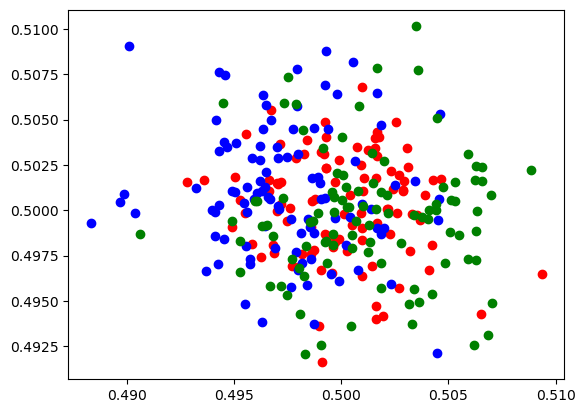

In [251]:
state = np.array([0.5,0.5,-1.0])

fw_samples = np.random.multivariate_normal(np.dot(models['FORWARD']['coeffs'], np.append(state, 1)), models['FORWARD']['cov'], 100)
left_samples = np.random.multivariate_normal(np.dot(models['LEFT']['coeffs'], np.append(state, 1)), models['LEFT']['cov'], 100)
right_samples = np.random.multivariate_normal(np.dot(models['RIGHT']['coeffs'], np.append(state, 1)), models['RIGHT']['cov'], 100)
plt.scatter(fw_samples[:,0], fw_samples[:,1], c='r', label='forward')
plt.scatter(left_samples[:,0], left_samples[:,1], c='b', label='left')
plt.scatter(right_samples[:,0], right_samples[:,1], c='g', label='right')

# Regression with Mutivariate OLS

In [95]:
from statsmodels.multivariate.multivariate_ols import _MultivariateOLS as MultivariateLS

fw_model = MultivariateLS(fw_endog, fw_exog).fit()
dir(fw_model)



['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fittedmod',
 'design_info',
 'endog_names',
 'exog_names',
 'mv_test',
 'summary']